In [20]:
# Loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Load dataset
child_care = pd.read_csv('nationaldatabaseofchildcareprices.csv')
child_care.head()

,State_Name,State_Abbreviation,County_Name,County_FIPS_Code,StudyYear,UNR_16,FUNR_16,MUNR_16,UNR_20to64,FUNR_20to64,...,MFCCToddler,MFCCToddler_flag,MFCCPreschool,MFCCPreschool_flag,_75FCCInfant,_75FCCInfant_flag,_75FCCToddler,_75FCCToddler_flag,_75FCCPreschool,_75FCCPreschool_flag
0,Alabama,AL,Autauga County,1001,2008,5.4,4.4,6.3,4.6,3.5,...,$83.45,3.0,$81.40,1.0,$97.40,1.0,$97.40,3.0,$95.00,1.0
1,Alabama,AL,Autauga County,1001,2009,5.9,5.7,6.1,4.8,4.6,...,$87.39,3.0,$85.68,1.0,$102.00,1.0,$102.00,3.0,$100.00,1.0
2,Alabama,AL,Autauga County,1001,2010,6.2,5.6,6.8,5.1,4.6,...,$91.33,3.0,$89.96,1.0,$106.60,1.0,$106.60,3.0,$105.00,1.0
3,Alabama,AL,Autauga County,1001,2011,7.6,8.1,7.0,6.2,6.3,...,$95.28,3.0,$94.25,1.0,$111.20,1.0,$111.20,3.0,$110.00,1.0
4,Alabama,AL,Autauga County,1001,2012,8.6,8.9,8.3,6.7,6.4,...,$99.22,3.0,$98.53,1.0,$115.80,1.0,$115.80,3.0,$115.00,1.0


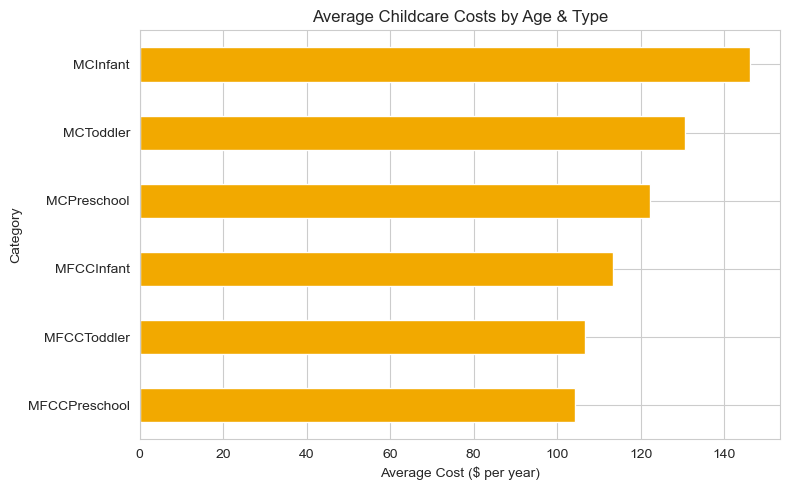

In [39]:
# Avg childcare costs

cols = ["MCInfant","MCToddler","MCPreschool","MFCCInfant","MFCCToddler","MFCCPreschool"]

# strip $ and commas, then convert to numeric
df_num = child_care[cols].apply(lambda s: s.astype(str).str.replace("$","", regex=False).str.replace(",","").astype(float))

# average across states
avg = df_num.mean().sort_values(ascending=False)

avg.iloc[::-1].plot(kind="barh", figsize=(8,5), color="#f2a900")
plt.title("Average Childcare Costs by Age & Type")
plt.xlabel("Average Cost ($ per year)")
plt.ylabel("Category")
plt.tight_layout()
plt.show()


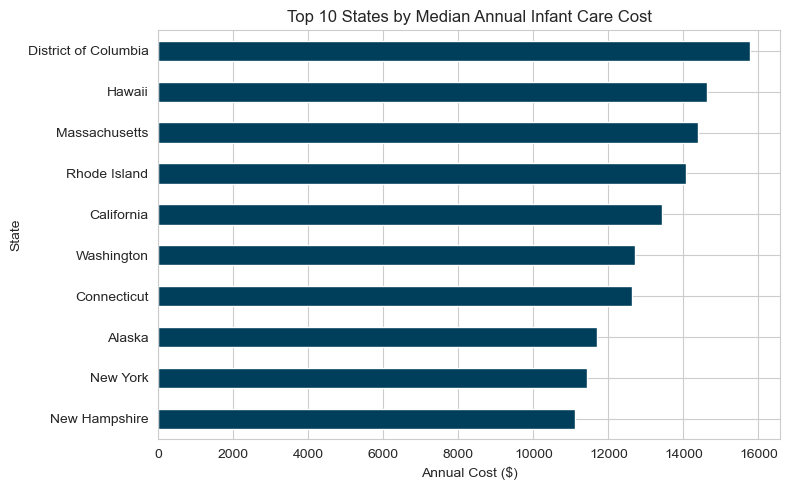

In [59]:
# Top 10 states by avg annual infant care cost

import matplotlib.pyplot as plt

# Convert weekly center-based infant care cost to annual
child_care["MCInfant_num"] = pd.to_numeric(
    child_care["MCInfant"].astype(str).str.replace(r"[^0-9.]", "", regex=True),
    errors="coerce"
) * 52

# Compute top 10 state medians
state_medians = (
    child_care.groupby("State_Name")["MCInfant_num"]
    .median()
    .sort_values(ascending=False)
    .head(10)
)

# Plot
plt.figure(figsize=(8,5))
state_medians.iloc[::-1].plot(kind="barh", color="#003f5c")  # dark blue

plt.title("Top 10 States by Median Annual Infant Care Cost")
plt.xlabel("Annual Cost ($)")
plt.ylabel("State")
plt.tight_layout()
plt.show()



State_Name
Washington              0.264994
California              0.247011
District of Columbia    0.245634
Massachusetts           0.224053
New York                0.204478
Hawaii                  0.197580
North Carolina          0.194463
Arizona                 0.193931
Maine                   0.191966
Colorado                0.187467
dtype: float64


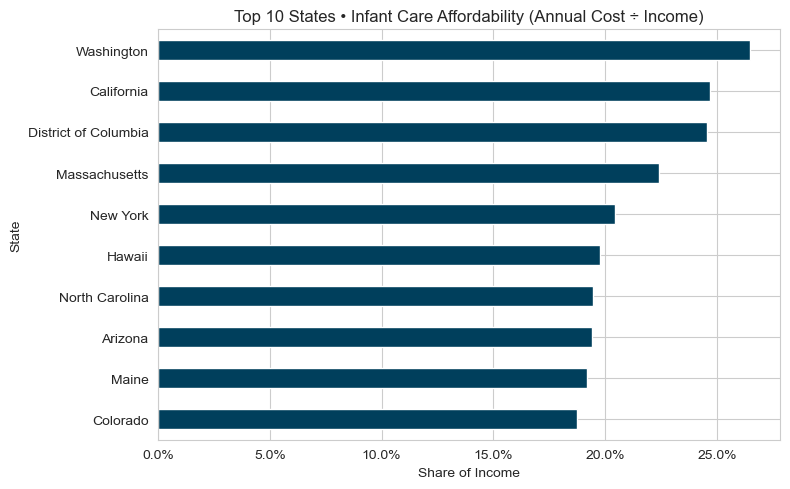

In [37]:
# Top 10 states by affordability

# State column
state_col = "State_Name" if "State_Name" in child_care.columns else "State"

# clean to numeric (remove $ and commas)
cost_weekly = pd.to_numeric(child_care["MCInfant"].astype(str).str.replace(r"[^0-9.]", "", regex=True), errors="coerce")
inc_annual  = pd.to_numeric(child_care["MHI"].astype(str).str.replace(r"[^0-9.]", "", regex=True), errors="coerce")

# annualize cost
cost_annual = cost_weekly * 52

# combine, drop NA, group, compute ratio of medians
g = (pd.DataFrame({state_col: child_care[state_col], "cost": cost_annual, "inc": inc_annual})
       .dropna(subset=[state_col, "cost", "inc"])
       .groupby(state_col).agg({"cost":"median", "inc":"median"}))

g = g[g["inc"] > 0]
aff = (g["cost"] / g["inc"]).sort_values(ascending=False).head(10)

print(aff)

from matplotlib.ticker import PercentFormatter
ax = aff.iloc[::-1].plot(kind="barh", figsize=(8,5), color="#003f5c")
ax.set_title("Top 10 States • Infant Care Affordability (Annual Cost ÷ Income)")
ax.set_xlabel("Share of Income")
ax.set_ylabel("State")
ax.xaxis.set_major_formatter(PercentFormatter(1.0))
plt.tight_layout()
plt.show()


Correlation between affordability ratio and female LFPR: -0.139
Data points plotted: 23593


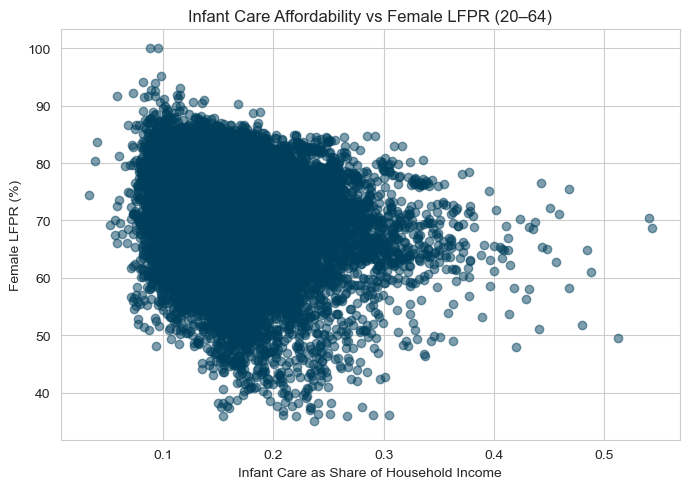

In [41]:
# Affordability vs female labor force participation

# Clean numeric fields
cost_weekly = pd.to_numeric(
    child_care["MCInfant"].astype(str).str.replace(r"[^0-9.]", "", regex=True),
    errors="coerce"
)

inc_annual = pd.to_numeric(
    child_care["MHI"].astype(str).str.replace(r"[^0-9.]", "", regex=True),
    errors="coerce"
)

flfpr = pd.to_numeric(child_care["FLFPR_20to64"], errors="coerce")

# annual cost
cost_annual = cost_weekly * 52

# afford ratio
aff_ratio = cost_annual / inc_annual

# filter + corr
mask = aff_ratio.notna() & flfpr.notna() & (inc_annual > 0)
corr = np.corrcoef(aff_ratio[mask], flfpr[mask])[0, 1]

print(f"Correlation between affordability ratio and female LFPR: {corr:.3f}")
print(f"Data points plotted: {mask.sum()}")

plt.figure(figsize=(7,5))
plt.scatter(aff_ratio[mask], flfpr[mask], alpha=0.5, color="#003f5c")
plt.title("Infant Care Affordability vs Female LFPR (20–64)")
plt.xlabel("Infant Care as Share of Household Income")
plt.ylabel("Female LFPR (%)")
plt.tight_layout()
plt.show()



In [25]:
# Do single parents feel the cost of child care more? How does this affect workforce participation?

# clean affordability (annual infant care / income)
cost_weekly = pd.to_numeric(child_care["MCInfant"].astype(str).str.replace(r"[^0-9.]", "", regex=True), errors="coerce")
inc_annual  = pd.to_numeric(child_care["MHI"].astype(str).str.replace(r"[^0-9.]", "", regex=True), errors="coerce")
aff_ratio   = (cost_weekly * 52) / inc_annual

# single mother households with kids under 6
single_m = pd.to_numeric(child_care["H_Under6_SingleM"], errors="coerce")

# quick correlation
mask = aff_ratio.notna() & single_m.notna() & (inc_annual > 0)
corr_single = np.corrcoef(aff_ratio[mask], single_m[mask])[0, 1]

print(f"Correlation between affordability burden and # single-mother households (under 6): {corr_single:.3f}")


Correlation between affordability burden and # single-mother households (under 6): 0.144


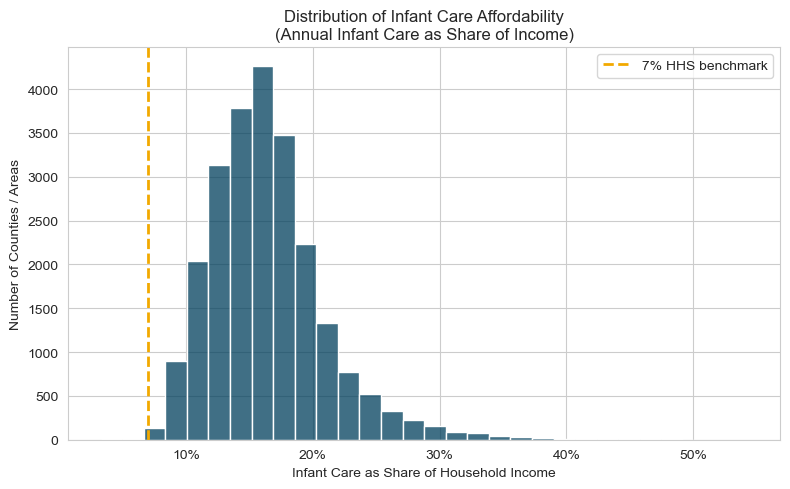

In [49]:
# Distribution of Infant Care Affordability (Histogram)

# Color palette (dark blue + mustard)
dark_blue = "#003f5c"
mustard   = "#f2a900"

sns.set_style("whitegrid")
sns.set_palette([dark_blue, mustard])

from matplotlib.ticker import PercentFormatter

# Recompute affordability ratio (annual infant care cost / annual income)
cost_weekly = pd.to_numeric(
    child_care["MCInfant"].astype(str).str.replace(r"[^0-9.]", "", regex=True),
    errors="coerce"
)
inc_annual = pd.to_numeric(
    child_care["MHI"].astype(str).str.replace(r"[^0-9.]", "", regex=True),
    errors="coerce"
)

aff_ratio = (cost_weekly * 52) / inc_annual

mask = aff_ratio.notna() & (inc_annual > 0)
aff_clean = aff_ratio[mask]

plt.figure(figsize=(8,5))
sns.histplot(aff_clean, bins=30, color=dark_blue, edgecolor="white")
plt.axvline(0.07, color=mustard, linestyle="--", linewidth=2, label="7% HHS benchmark")

plt.title("Distribution of Infant Care Affordability\n(Annual Infant Care as Share of Income)")
plt.xlabel("Infant Care as Share of Household Income")
plt.ylabel("Number of Counties / Areas")
plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))
plt.legend()
plt.tight_layout()
plt.show()

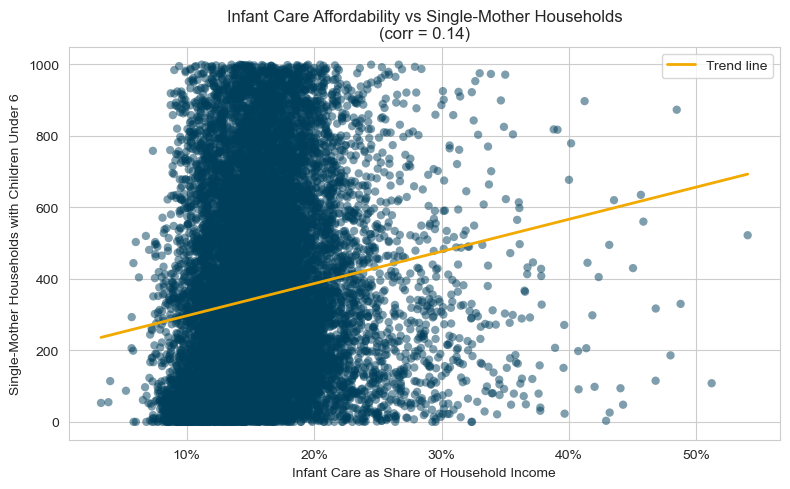

In [47]:
# Affordability vs. Single Mother Households (Scatter + Trend Line)

# Clean affordability (annual infant care / income)
cost_weekly = pd.to_numeric(
    child_care["MCInfant"].astype(str).str.replace(r"[^0-9.]", "", regex=True),
    errors="coerce"
)
inc_annual = pd.to_numeric(
    child_care["MHI"].astype(str).str.replace(r"[^0-9.]", "", regex=True),
    errors="coerce"
)
aff_ratio = (cost_weekly * 52) / inc_annual

# Single-mother households with kids under 6
single_m = pd.to_numeric(child_care["H_Under6_SingleM"], errors="coerce")

mask = aff_ratio.notna() & single_m.notna() & (inc_annual > 0)

# Correlation for annotation (you already computed corr_single, but recomputing here is fine)
corr_single = np.corrcoef(aff_ratio[mask], single_m[mask])[0, 1]

plt.figure(figsize=(8,5))
plt.scatter(aff_ratio[mask], single_m[mask], alpha=0.5, color=dark_blue, edgecolor="none")

# Simple linear trend line
x_vals = np.linspace(aff_ratio[mask].min(), aff_ratio[mask].max(), 100)
coef = np.polyfit(aff_ratio[mask], single_m[mask], 1)
y_vals = coef[0] * x_vals + coef[1]
plt.plot(x_vals, y_vals, color=mustard, linewidth=2, label="Trend line")

plt.title(f"Infant Care Affordability vs Single-Mother Households\n(corr = {corr_single:.2f})")
plt.xlabel("Infant Care as Share of Household Income")
plt.ylabel("Single-Mother Households with Children Under 6")
plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))
plt.legend()
plt.tight_layout()
plt.show()

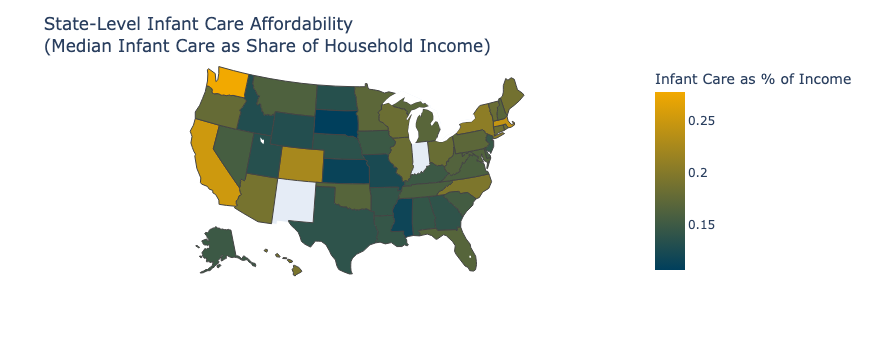

In [61]:
# Spatial Map

import plotly.express as px

# Raffordability ratio (annual infant care cost / annual income)
cost_weekly = pd.to_numeric(
    child_care["MCInfant"].astype(str).str.replace(r"[^0-9.]", "", regex=True),
    errors="coerce"
)
inc_annual = pd.to_numeric(
    child_care["MHI"].astype(str).str.replace(r"[^0-9.]", "", regex=True),
    errors="coerce"
)
aff_ratio = (cost_weekly * 52) / inc_annual

# existing columns
state_col = "State_Name"
abbr_col  = "State_Abbreviation"

# Build the state-level dataset
state_aff = (
    pd.DataFrame({
        state_col: child_care[state_col],
        abbr_col:  child_care[abbr_col],
        "aff_ratio": aff_ratio
    })
    .dropna(subset=[state_col, abbr_col, "aff_ratio"])
    .groupby([state_col, abbr_col], as_index=False)["aff_ratio"]
    .median()
)

# Choropleth using dark-blue to mustard palette
fig = px.choropleth(
    state_aff,
    locations=abbr_col,
    locationmode="USA-states",
    color="aff_ratio",
    scope="usa",
    color_continuous_scale=["#003f5c", "#f2a900"],   
    labels={"aff_ratio": "Infant Care as % of Income"},
    hover_data={state_col: True, abbr_col: False, "aff_ratio": ":.1%"}
)

fig.update_layout(
    title_text="State-Level Infant Care Affordability<br>(Median Infant Care as Share of Household Income)",
    geo=dict(bgcolor="rgba(0,0,0,0)")
)

fig.show()

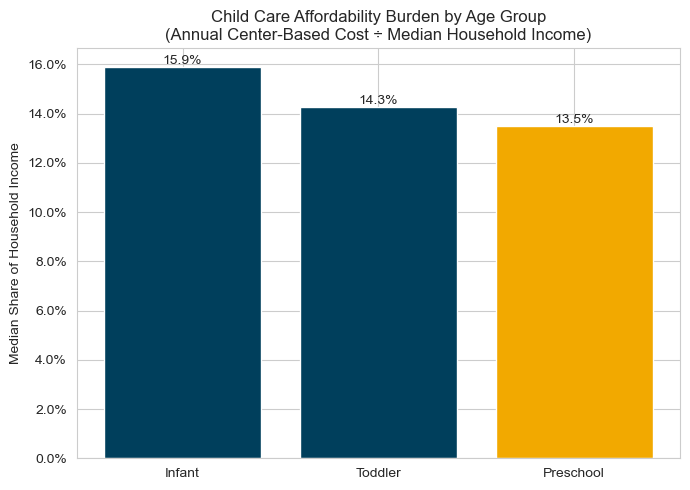

In [57]:
# Burden by Age Group (Infant vs. Toddler vs Preschool)

from matplotlib.ticker import PercentFormatter

# Clean weekly costs
mc_infant   = pd.to_numeric(
    child_care["MCInfant"].astype(str).str.replace(r"[^0-9.]", "", regex=True),
    errors="coerce"
)
mc_toddler  = pd.to_numeric(
    child_care["MCToddler"].astype(str).str.replace(r"[^0-9.]", "", regex=True),
    errors="coerce"
)
mc_preschool = pd.to_numeric(
    child_care["MCPreschool"].astype(str).str.replace(r"[^0-9.]", "", regex=True),
    errors="coerce"
)

# Income (annual)
inc_annual = pd.to_numeric(
    child_care["MHI"].astype(str).str.replace(r"[^0-9.]", "", regex=True),
    errors="coerce"
)

# Annual cost and affordability ratios
infant_ratio = (mc_infant * 52) / inc_annual
toddler_ratio = (mc_toddler * 52) / inc_annual
preschool_ratio = (mc_preschool * 52) / inc_annual

mask_infant = infant_ratio.notna() & (inc_annual > 0)
mask_toddler = toddler_ratio.notna() & (inc_annual > 0)
mask_preschool = preschool_ratio.notna() & (inc_annual > 0)

# National median affordability burden by age group
age_labels = ["Infant", "Toddler", "Preschool"]
burdens = [
    infant_ratio[mask_infant].median(),
    toddler_ratio[mask_toddler].median(),
    preschool_ratio[mask_preschool].median()
]

plt.figure(figsize=(7,5))
bars = plt.bar(age_labels, burdens, color=[dark_blue, dark_blue, mustard])

plt.ylabel("Median Share of Household Income")
plt.title("Child Care Affordability Burden by Age Group\n(Annual Center-Based Cost ÷ Median Household Income)")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

for b in bars:
    height = b.get_height()
    plt.text(
        b.get_x() + b.get_width()/2,
        height,
        f"{height:.1%}",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()